# 03 - Baseline Models Training

## Section D: Machine Learning Model Design

This notebook implements and compares two scalable machine learning models:
1. **Random Forest** - Tree-based ensemble (scalable)
2. **XGBoost** - Gradient boosting (state-of-art for tabular data)

Both models are:
- Unsuitable for small toy datasets (require substantial data)
- Scalable through parallel processing
- Capable of handling class imbalance

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')

from config import PROCESSED_DATA_DIR, RESULTS_DIR, RANDOM_STATE
from src.models import ModelTrainer, train_all_models
from src.evaluation import (
    compute_metrics, evaluate_at_scales, 
    plot_roc_curves, plot_precision_recall_curves,
    generate_evaluation_report
)
from src.visualization import (
    plot_class_distribution, plot_confusion_matrix,
    plot_feature_importance, plot_metrics_comparison,
    create_summary_dashboard
)
from sklearn.metrics import confusion_matrix

print('Imports successful!')

Imports successful!


In [2]:
# Load processed data
df = pd.read_csv(PROCESSED_DATA_DIR / 'loan_data_processed.csv')

print('='*60)
print('DATASET OVERVIEW')
print('='*60)
print(f'Total records: {len(df):,}')
print(f'Total features: {len(df.columns)}')
print(f'Memory usage: {df.memory_usage(deep=True).sum() / 1e6:.2f} MB')
print(f'\nTarget distribution:')
print(df['default'].value_counts())
print(f'\nDefault rate: {df["default"].mean()*100:.2f}%')

DATASET OVERVIEW
Total records: 1,306,387
Total features: 24
Memory usage: 688.45 MB

Target distribution:
default
0    1043940
1     262447
Name: count, dtype: int64

Default rate: 20.09%


## Model 1: Random Forest Classifier

### Why Random Forest fits the data characteristics:
- **Handles mixed feature types**: Numerical and categorical features
- **Robust to outliers**: Tree-based splitting not affected by extreme values
- **Feature importance**: Built-in importance scores for interpretability
- **Scalable**: Parallelizable with n_jobs=-1
- **Handles imbalance**: class_weight='balanced' adjusts for class distribution

In [3]:
# Initialize trainer
trainer = ModelTrainer(random_state=RANDOM_STATE)

# Prepare data
X_train, X_test, y_train, y_test = trainer.prepare_data(df, target_col='default')

PREPARING DATA FOR MODELING

Categorical features (6): ['grade', 'sub_grade', 'verification_status', 'home_ownership', 'addr_state', 'purpose']
Numerical features (16): 16 columns

Training set: 1,045,109 samples
Test set: 261,278 samples
Class distribution in train: {0: np.int64(835152), 1: np.int64(209957)}
Class distribution in test: {0: np.int64(208788), 1: np.int64(52490)}


In [4]:
# Train Random Forest
print('\n' + '='*60)
print('TRAINING RANDOM FOREST')
print('='*60)

rf_model, rf_results = trainer.train_model(
    'RandomForest', 
    X_train, y_train, 
    X_test, y_test,
    tune_hyperparameters=False
)


TRAINING RANDOM FOREST

TRAINING: RandomForest
Description: Tree-based ensemble. Handles non-linearity, feature importance.

Training time: 31.95 seconds

--- Evaluation Results ---

Metric               Train       Test
-------------------------------------
accuracy            1.0000     0.8006
precision           1.0000     0.5329
recall              0.9998     0.0589
f1                  0.9999     0.1060
roc_auc             1.0000     0.7025

Confusion Matrix (Test):
[[206079   2709]
 [ 49400   3090]]

Classification Report (Test):
              precision    recall  f1-score   support

 Non-Default       0.81      0.99      0.89    208788
     Default       0.53      0.06      0.11     52490

    accuracy                           0.80    261278
   macro avg       0.67      0.52      0.50    261278
weighted avg       0.75      0.80      0.73    261278




Top 15 Most Important Features (Random Forest):
             feature  importance
                 dti    0.081527
            int_rate    0.079922
           revol_bal    0.075954
          revol_util    0.074748
credit_history_years    0.073548
          annual_inc    0.068810
         installment    0.063494
           total_acc    0.059423
          addr_state    0.054487
           sub_grade    0.051437
            open_acc    0.048986
         funded_amnt    0.043100
           loan_amnt    0.042567
          emp_length    0.035828
               grade    0.035162


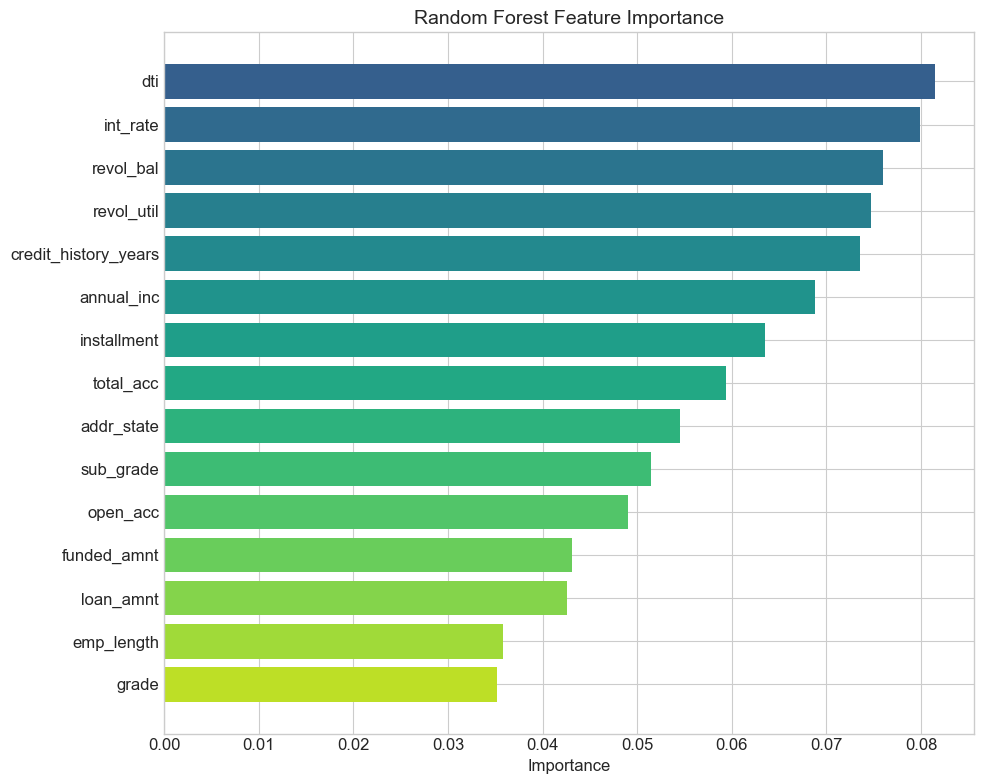

In [5]:
# Random Forest Feature Importance
rf_importance = trainer.get_feature_importance('RandomForest')
print('\nTop 15 Most Important Features (Random Forest):')
print(rf_importance.head(15).to_string(index=False))

fig = plot_feature_importance(rf_importance, top_n=15, 
                              title='Random Forest Feature Importance')
plt.savefig(RESULTS_DIR / 'rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Model 2: XGBoost Classifier

### Why XGBoost fits the data characteristics:
- **State-of-the-art for tabular data**: Consistently wins competitions
- **Handles imbalance**: scale_pos_weight parameter
- **Regularization**: L1/L2 regularization prevents overfitting
- **Scalable**: tree_method='hist' for faster training on large datasets
- **Missing value handling**: Built-in handling of missing values

In [6]:
# Train XGBoost
print('\n' + '='*60)
print('TRAINING XGBOOST')
print('='*60)

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f'\nImbalance ratio: {imbalance_ratio:.2f}')

xgb_model, xgb_results = trainer.train_model(
    'XGBoost', 
    X_train, y_train, 
    X_test, y_test,
    tune_hyperparameters=False
)


TRAINING XGBOOST

Imbalance ratio: 3.98

TRAINING: XGBoost
Description: Gradient boosting. State-of-art for tabular data. Scalable.

Training time: 1.45 seconds

--- Evaluation Results ---

Metric               Train       Test
-------------------------------------
accuracy            0.8073     0.8028
precision           0.6196     0.5556
recall              0.1060     0.0926
f1                  0.1810     0.1587
roc_auc             0.7429     0.7218

Confusion Matrix (Test):
[[204901   3887]
 [ 47630   4860]]

Classification Report (Test):
              precision    recall  f1-score   support

 Non-Default       0.81      0.98      0.89    208788
     Default       0.56      0.09      0.16     52490

    accuracy                           0.80    261278
   macro avg       0.68      0.54      0.52    261278
weighted avg       0.76      0.80      0.74    261278




Top 15 Most Important Features (XGBoost):
            feature  importance
          sub_grade    0.409644
              grade    0.232646
               term    0.088753
     home_ownership    0.050144
verification_status    0.020403
                dti    0.017580
        funded_amnt    0.015432
         addr_state    0.013975
           int_rate    0.013467
     inq_last_6mths    0.013049
         annual_inc    0.012807
        installment    0.012583
         emp_length    0.012247
            pub_rec    0.011971
          loan_amnt    0.011878


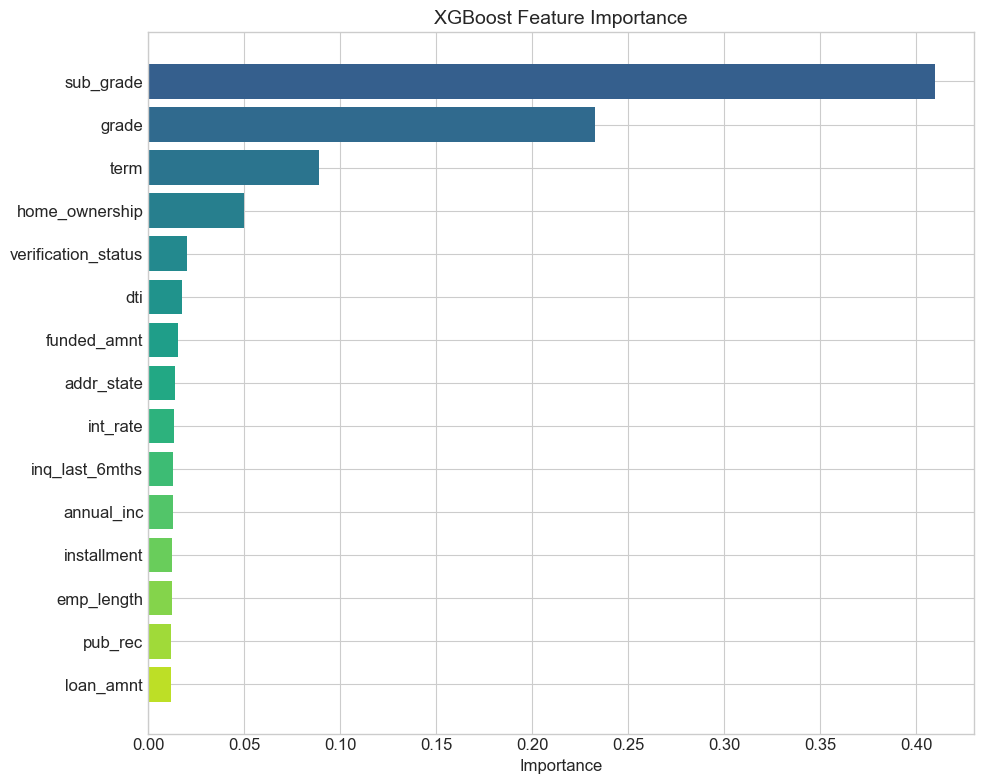

In [7]:
# XGBoost Feature Importance
xgb_importance = trainer.get_feature_importance('XGBoost')
print('\nTop 15 Most Important Features (XGBoost):')
print(xgb_importance.head(15).to_string(index=False))

fig = plot_feature_importance(xgb_importance, top_n=15, 
                              title='XGBoost Feature Importance')
plt.savefig(RESULTS_DIR / 'xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Model Comparison

In [8]:
print('\n' + '='*60)
print('MODEL COMPARISON')
print('='*60)

comparison_df = trainer.compare_models()
print(comparison_df.to_string(index=False))


MODEL COMPARISON
       Model  Train_accuracy  Train_precision  Train_recall  Train_f1  Train_roc_auc  Test_accuracy  Test_precision  Test_recall  Test_f1  Test_roc_auc  Training_Time
RandomForest        0.999969         1.000000      0.999848  0.999924       1.000000       0.800561        0.532850     0.058868 0.106023      0.702535      31.950057
     XGBoost        0.807322         0.619597      0.105955  0.180964       0.742863       0.802827        0.555619     0.092589 0.158728      0.721830       1.447252


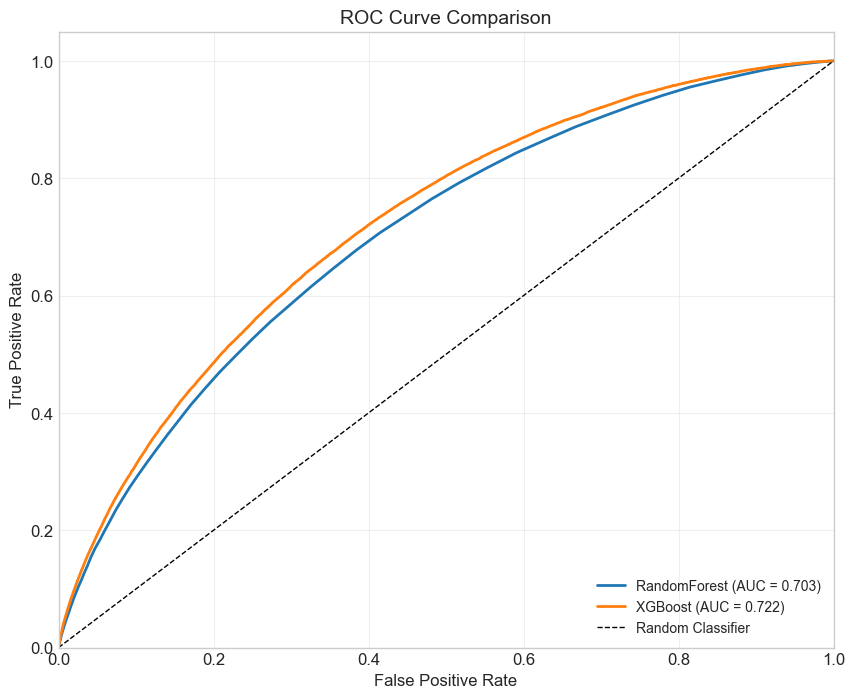

In [9]:
# Plot ROC curves
fig = plot_roc_curves(trainer.models, X_test, y_test,
                      save_path=RESULTS_DIR / 'roc_comparison.png')
plt.show()

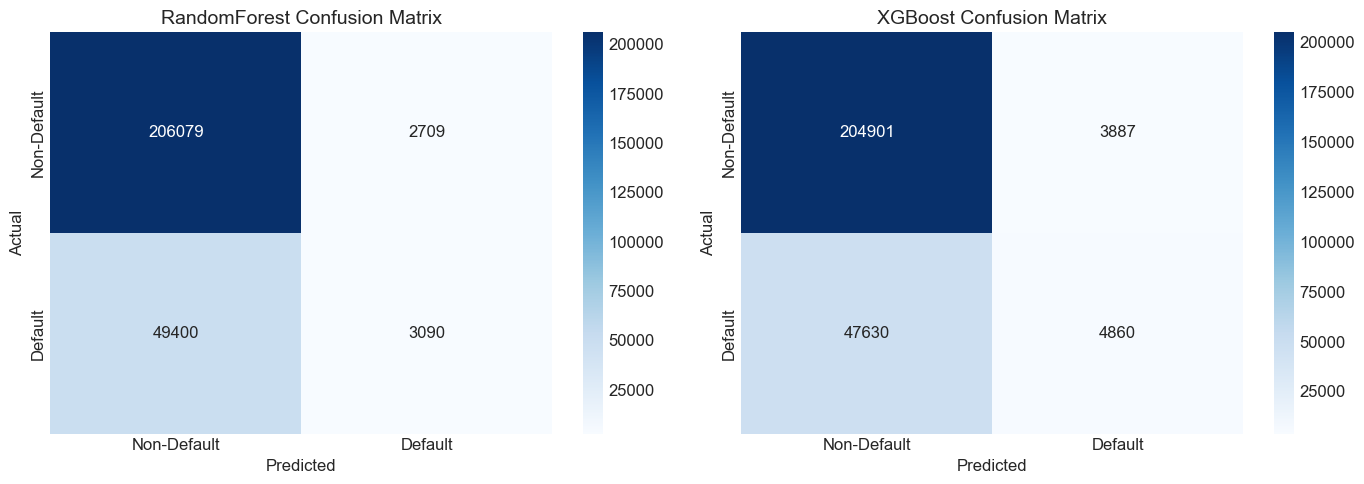

In [10]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, model) in zip(axes, trainer.models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-Default', 'Default'],
                yticklabels=['Non-Default', 'Default'])
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
print('\n' + '='*60)
print('COMPUTATIONAL COST ANALYSIS')
print('='*60)

print(f'\nTraining Data Size: {len(X_train):,} samples x {X_train.shape[1]} features')
print(f'Test Data Size: {len(X_test):,} samples')

for model_name, results in trainer.results.items():
    train_time = results['training_time']
    throughput = len(X_train) / train_time
    print(f'{model_name}: {train_time:.2f}s ({throughput:,.0f} samples/s)')


COMPUTATIONAL COST ANALYSIS

Training Data Size: 1,045,109 samples x 22 features
Test Data Size: 261,278 samples
RandomForest: 31.95s (32,711 samples/s)
XGBoost: 1.45s (722,133 samples/s)


In [12]:
# Save results
comparison_df.to_csv(RESULTS_DIR / 'model_comparison.csv', index=False)
rf_importance.to_csv(RESULTS_DIR / 'rf_feature_importance.csv', index=False)
xgb_importance.to_csv(RESULTS_DIR / 'xgb_feature_importance.csv', index=False)

import joblib
for name, model in trainer.models.items():
    joblib.dump(model, RESULTS_DIR / f'{name.lower()}_model.joblib')

print('Results and models saved!')

Results and models saved!
